# Welcome to the OnSSET Notebook

This Jupyter based interface is built on the [OnSSET](http://www.onsset.org/) tool developed to provide an easy and quick way to generate electrification investment scenarios.

#### Start by importing the code 

In [1]:
from onsset import *
from IPython.display import display, Markdown, HTML
%matplotlib inline
%run funcs.ipynb
%run detailed_tech_parameters.ipynb
import warnings
import re
warnings.filterwarnings('ignore')
import time
import matplotlib.pylab as plt
import seaborn as sns
import tkinter as tk
from tkinter import filedialog, messagebox
root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

''

### 1. GIS data selection

First, run the cell below to browse to the directory your input CSV file is located at and select the input file. 

In [2]:
messagebox.showinfo('OnSSET', 'Open the input file with calibrated GIS data')
input_file = filedialog.askopenfilename()

onsseter = SettlementProcessor(input_file)
onsseter.conditioning()

In [3]:
messagebox.showinfo('OnSSET', 'Open the file with hourly PV data')
pv_path = filedialog.askopenfilename()
messagebox.showinfo('OnSSET', 'Open the file with hourly Wind data')
wind_path = filedialog.askopenfilename()

In [4]:
messagebox.showinfo('OnSSET', 'Open the existing MV lines')
existing_mv = filedialog.askopenfilename()
x_mv_exist, y_mv_exist = onsseter.start_extension_points(existing_mv)
x_coordinates = x_mv_exist
y_coordinates = y_mv_exist

In [5]:
col_name = max(
    [c for c in onsseter.df.columns if c.startswith("FinalElecCode")],
    key=lambda x: int(re.search(r"\d{4}$", x).group())
)
existing_loc_x = np.array(onsseter.df.loc[onsseter.df[col_name] == 1, SET_X_DEG].tolist())
existing_loc_y = np.array(onsseter.df.loc[onsseter.df[col_name] == 1, SET_Y_DEG].tolist())

In [6]:
x_coordinates = np.append(x_mv_exist, existing_loc_x)
y_coordinates = np.append(y_mv_exist, existing_loc_y)

# 2. Modelling period and target electrification rate

Next, define the modelling period and the electrification rate to be achieved by the end of the analysis. Further down you will also define an intermediate year and target.

In [7]:
start_year = 2024  # This should be the same as in the calibration file
end_year = 2030

end_electrification_rate_target = 1 # E.g. 1 for 100% electrification rate or 0.80 for 80% electrification rate 

yearsofanalysis = [end_year]
eleclimits = {end_year: end_electrification_rate_target}
time_steps = {end_year: end_year-start_year}

# 3. Enter country specific data

To run scenarios, the user can customize a large number of variables describing the social - economic - technological environment in the selected country. 

### a. Demographics and Social components

In [8]:
end_year_pop = 26000000         ### Write the expected population in the END year (e.g. 2030) 

urban_ratio_end_year = 0.36     ### Write the urban population population ratio in the END year (e.g. 2030)

num_people_per_hh_urban = 5     ### Write the number of people per household in urban areas
num_people_per_hh_rural = 5   ### Write the number of people per household in rural areas

### b. Technology specifications & costs

The cell below contains all the information that is used to calculate the levelized costs for all the technologies, including grid. These default values should be updated to reflect the most accurate values in the country. There are currently 6 potential technologies to include in the model:
 * Grid
 * 
PV Hybrid Mini-grid
 * Wind Mini-grid
 * Hydro Mini-grid
 * PV Stand-alone systems
 * Diesel stand-alone systems

The key technology input parameters can be defined below. More detailed parameters for each parameter can be found and edited in the **detailed_tech_parameters** notebook.

#### Centralized grid parameters 

In [9]:
grid_generation_cost = 0.10                ### This is the grid cost electricity USD/kWh as expected in the end year of the analysis
grid_power_plants_capital_cost = 2500      ### The cost in USD/kW is for capacity upgrades of the grid
grid_losses = 0.15                         ### The fraction of electricity lost in transmission and distribution (percentage)
grid_emission_factor = 745                 ### This is the average emissions from grid generation (gCO2/kWh), see e.g. https://unfccc.int/documents/461676

annual_new_grid_connections_limit = 999999999 # This is the maximum amount of new households that can be connected to the grid in one year
annual_grid_cap_gen_limit = 9999999        # This is the maximum generation capacity (MW) that can be added to the grid in one year

In [10]:
# Grid Transmission and distribution costs
hv_line_capacity=161 # kV
hv_line_cost=106000 # USD/km

grid_mv_line_capacity=33 # kV
grid_mv_line_cost=20000 # USD/km
grid_mv_line_max_length=100 # km
grid_MV_line_amperage_limit = 275  # Ampere (A)

grid_lv_line_capacity=0.4 #kV
grid_lv_line_max_length=1 # km
grid_lv_line_cost=15000 # USD/km

grid_service_Transf_type=75  # kVA
grid_service_Transf_cost=9000  # $/unit
grid_max_nodes_per_serv_trans=95  # maximum number of nodes served by each service (MV/LV) transformer

hv_mv_transformer_type = 16000 #kVA
hv_mv_transformer_cost = 980000 # USD/unit

#### Off-grid technology parameters

In [11]:
min_mg_size = 100             # Minimum number of households in a settlement for mini-grids to be considered
mg_min_grid_dist = 0          # Minimum distance from existing MV lines for mini-grids to be considered as an option

In [12]:
diesel_price = 1.43                    ### This is the diesel price in USD/liter as expected in the end year of the analysis

In [13]:
# PV and Wind hybrid mini-grid costs
pv_cost = 1400                      # PV panel costs including BoS (PV inverter, charge controller) (USD/kW)
battery_cost = 550                 # battery capital cost, USD/kWh of storage capacity                    
inverter_cost  = 598             # Battery inverter, USD/kW
diesel_gen_cost = 500              # diesel generator capital cost, USD/kW rated power
wind_cost = 2500                   # Wind turbine capital cost, USD/kW peak power

inverter_life=8    # Battery inverter expected lifetime in mini-grid, years
diesel_life=10      # diesel generator expected lifetime in mini-grid, years
pv_life=25          # PV panel expected lifetime in mini-grid, years
        
lpsp_max=0.02         # maximum loss of load allowed over the year, in share of kWh (e.g. 0.1 means that the mini-grid will be able to meet at least 90% of the demand over the year)
max_diesel = 0.0     # Maximum share of generation that can come from diesel generators (0-1). Set to 0 for fully renewable mini-grids

In [14]:
mg_hydro_capital_cost = {float("inf"): 15000}      ### Mini-grid Hydro capital cost (USD/kW) as expected in the years of the analysis

In [15]:
# Mini-grid distribution network spcification

mg_mv_line_capacity=33 # kV
mg_mv_line_cost = 25000 # USD/kW
mg_MV_line_amperage_limit = 275  # Ampere (A)

mg_lv_line_capacity=0.4 #kV
mg_lv_line_max_length=1 # km
mg_lv_line_cost=15000 # USD/km

mg_service_Transf_type=75  # kVA
mg_service_Transf_cost=9000  # $/unit
mg_max_nodes_per_serv_trans=95  # maximum number of nodes served by each service (MV/LV) transformer

In [16]:
sa_pv_capital_cost_1 = 11600          ### Solar Home System capital cost (USD/kW) for household systems under 20 W
sa_pv_capital_cost_2 = 7500          ### Solar Home System capital cost (USD/kW) for household systems between 21-50 W
sa_pv_capital_cost_3 = 7500           ### Solar Home System capital cost (USD/kW) for household systems between 51-100 W
sa_pv_capital_cost_4 = 8000           ### Solar Home System capital cost (USD/kW) for household systems between 101-1000 W
sa_pv_capital_cost_5 = 8000           ### Solar Home System capital cost (USD/kW) for household systems over 1 kW

shs_lifetime = 5                      ### Expected technology lifetime of Solar Home System

The cells below contain additional technology specifications

In [17]:
grid_discount_rate = 0.12 # E.g. 0.08 means a discount rate of 8%
mini_grid_discount_rate = 0.12
standalone_discount_rate = 0.12

### c. Electricity demand target

For the second lever, enter the target tier (level of electricity access) for urban and rural households respectively. This can take a value between "1" (lowest level of electricity access) and "5" (highest level of electricity access) as in ESMAPs Multi-Tier Framework for Measuring Electricity Access (found <a href="https://www.esmap.org/node/55526" target="_blank">here</a>). Alternatively, enter "6" to use a distribution of the tiers across the country based on poverty levels and GDP according to the methodology found <a href="https://www.mdpi.com/1996-1073/12/7/1395" target="_blank">here</a>.   

*On the GEP Explorer, the following three electricity demand targets are used:*

*Top down demand target - Low: In this case, all urban clusters are tergeted to reach the current average consumption level of electrified households, and rural settlements are assigned Tier 1.* 

*Top down demand target - High: In this case, all urban clusters are tergeted to reach one Tier higher than the current average consumption level of electrified households, and rural settlements are assigned Tier 3.*

*Bottom up demand target (Poverty - GDP): In this case each settlement is assigned a demand target based on poverty and GDP levels as described in the methodology above. Choose "6" for both the urban_target_tier and rural_target_tier to use this option* 

In [18]:
# Define the annual household electricity targets to choose from
tier_1 = 20  # 43 refers to kWh/household/year. 
tier_2 = 300
tier_3 = 620
tier_4 = 1241
tier_5 = 3000

In [19]:
rural_cutoff_size = 100  # Any rural settlement with fewer households is considered a "small rural" settlement, rural settlements with larger population is considered "large rural" 

urban_target_tier = 4               # Target demand Tier for Urban settlements
rural_target_tier_large = 3        # Target demand Tier for large rural settlements
rural_target_tier_small = 1         # Target demand Tier for small rural settlements

In [20]:
productive_demand = 1                     # 1 if productive demand is defined and should be included, else 0

### d. Rollout plan
This lever reflects the electrification approach to be examined. On the GEP Explorer, there are currently two options in use:

**Nationwide Least Cost approach:** This options aims to achieve the electrification rate targets set for the intermediate and end year. For the years where the target is set below 100%, the algorithm prioritizes grid densification first (ramp up in already electrified clusters) then selection based on lowest invetsment cost per capita to choose which clusters to be electrified.

**Forced grid approach:** Forced grid under a defined buffer zone (auto_intensification set equal to X km) & least cost approach outside of the buffer zone.

In [27]:
auto_intensification = 0        # Buffer distance (km) for automatic intensification

max_grid_intensification_cost = 2500  # Maximum cost per household (USD/household) for forced grid intensification 

If using a target access rate less than 100%, choose how to select which settlements to electrify first. The options are:
* 1 = Select the most easily reached settlements first, based on lowest distance to main roads
* 2 = Select the most easily reached settlements, based on travel time
* 3 = Select the largest settlements first
* 4 = Select settlements based on the lowest investment cost per capita (low demand settlements first)

In [28]:
prio_choice = 1       # Select 1, 2, 3 or 4 as described above 

# 5. Start a scenario run, which calculate and compare technology costs for every settlement in the country

Based on the previous calculation this piece of code identifies the LCoE that every off-grid technology can provide, for each single populated settlement of the selected country. The cell then takes all the currently grid-connected points in the country, and looks at the points within a certain distance from them, to see if it is more economical to connect them to the grid, or to use one of the off-grid technologies calculated above. Once more points are connected to the grid, the process is repeated, so that new points close to those points might also be connected. This is repeated until there are no new points to connect to the grid.

In [29]:
grid_calc, mg_pv_hybrid_calc, mg_wind_hybrid_calc, mg_hydro_calc, sa_pv_calc, sa_diesel_calc, mg_pv_hybrid_params, mg_wind_hybrid_params, mg_diesel_params, mg_interconnection, grid_reliability_option, cnse, grid_reliability = init_tech_info(grid_losses, grid_power_plants_capital_cost, grid_generation_cost, grid_discount_rate, grid_mv_line_capacity,
                   grid_MV_line_amperage_limit, grid_mv_line_cost, grid_lv_line_capacity, grid_lv_line_cost, grid_lv_line_max_length, 
                   grid_service_Transf_type, grid_service_Transf_cost, grid_max_nodes_per_serv_trans,
                   mini_grid_discount_rate, mg_mv_line_capacity, mg_MV_line_amperage_limit, mg_mv_line_cost, mg_lv_line_capacity, 
                   mg_lv_line_cost, mg_lv_line_max_length, mg_service_Transf_type, mg_service_Transf_cost, mg_max_nodes_per_serv_trans,
                   mg_hydro_capital_cost, shs_lifetime, standalone_discount_rate, sa_pv_capital_cost_1, sa_pv_capital_cost_2, sa_pv_capital_cost_3, 
                   sa_pv_capital_cost_4, sa_pv_capital_cost_5, min_mg_size, diesel_gen_cost, battery_cost, pv_life, diesel_life, inverter_cost,
                   inverter_life, lpsp_max, max_diesel, diesel_price)

onsseter.df, new_lines_geojson = run_scenario(onsseter, end_year_pop, urban_ratio_end_year, start_year, end_year, yearsofanalysis, x_coordinates, y_coordinates, tier_1, 
                 tier_2, tier_3, tier_4, tier_5, hv_line_capacity, hv_line_cost, hv_mv_transformer_cost, hv_mv_transformer_type, eleclimits, time_steps, 
                 annual_new_grid_connections_limit, annual_grid_cap_gen_limit, num_people_per_hh_urban, num_people_per_hh_rural, urban_target_tier, 
                 rural_target_tier_large, rural_target_tier_small, rural_cutoff_size, mg_diesel_params, mg_wind_hybrid_params, wind_path, 
                 mg_pv_hybrid_params, pv_path, mg_hydro_calc, mg_wind_hybrid_calc, sa_pv_calc, mg_pv_hybrid_calc, min_mg_size, mg_min_grid_dist,
                 grid_generation_cost, grid_calc, sa_diesel_calc, max_grid_intensification_cost, auto_intensification, grid_mv_line_max_length, 
                 mg_interconnection, grid_reliability_option, cnse, grid_reliability, prio_choice, grid_emission_factor)

finalize_results(onsseter, yearsofanalysis)

Starting Tue Sep  2 14:56:37 2025
Optimize Wind Hybrid Systems Tue Sep  2 14:56:37 2025
Optimize MG Hybrid Systems Tue Sep  2 14:57:09 2025
Calculate Off-Grid LCOEs Tue Sep  2 14:58:06 2025
Calculate Grid LCOEs Tue Sep  2 14:58:07 2025
4327  new settlements connected to the grid Tue Sep  2 14:58:16 2025
3  new settlements connected to the grid Tue Sep  2 14:58:16 2025
15684  new settlements connected to the grid Tue Sep  2 14:58:58 2025
924  new settlements connected to the grid Tue Sep  2 14:59:12 2025
72  new settlements connected to the grid Tue Sep  2 14:59:25 2025
10  new settlements connected to the grid Tue Sep  2 14:59:37 2025
3  new settlements connected to the grid Tue Sep  2 14:59:50 2025
Calculating results columns Tue Sep  2 15:00:07 2025
The electrification rate achieved in 2030 is 100.0 %



# 6. Results, Summaries and Visualization
With all the calculations and grid-extensions complete, this block gets the final results on which technology was chosen for each point, how much capacity needs to be installed and what it will cost. Then the summaries, plots and maps are generated.

In [24]:
techs = ["Grid", "SA_PV", "MG_PVHybrid", "MG_Wind", "MG_Hydro"]
tech_codes = [1, 3, 5, 6, 7]

summary_table, columns = calc_summary_table(onsseter.df, yearsofanalysis)
display(Markdown('### Summary \n These are the summarized results of the selected country'))
summary_table

### Summary 
 These are the summarized results of the selected country

,Population2030,NewConnections2030,Capacity2030 (MW),Investment2030 (million USD),Emissions2030 (tCO2)
Grid_dens,12927929,1283945,311.96,1397.92,865.12
Grid_ext,8200395,1640077,280.41,1947.23,777.74
SA_PV,4829743,966354,11.31,262.29,0.00
MG_PV_Hybrid,41931,8300,3.51,12.74,0.00
MG_Wind,0,0,0.00,0.00,0.00
MG_Hydro,0,0,0.00,0.00,0.00
Non-electrified,0,0,0.00,0.00,0.00
Total,25999998,3898676,607.19,3620.18,1642.86


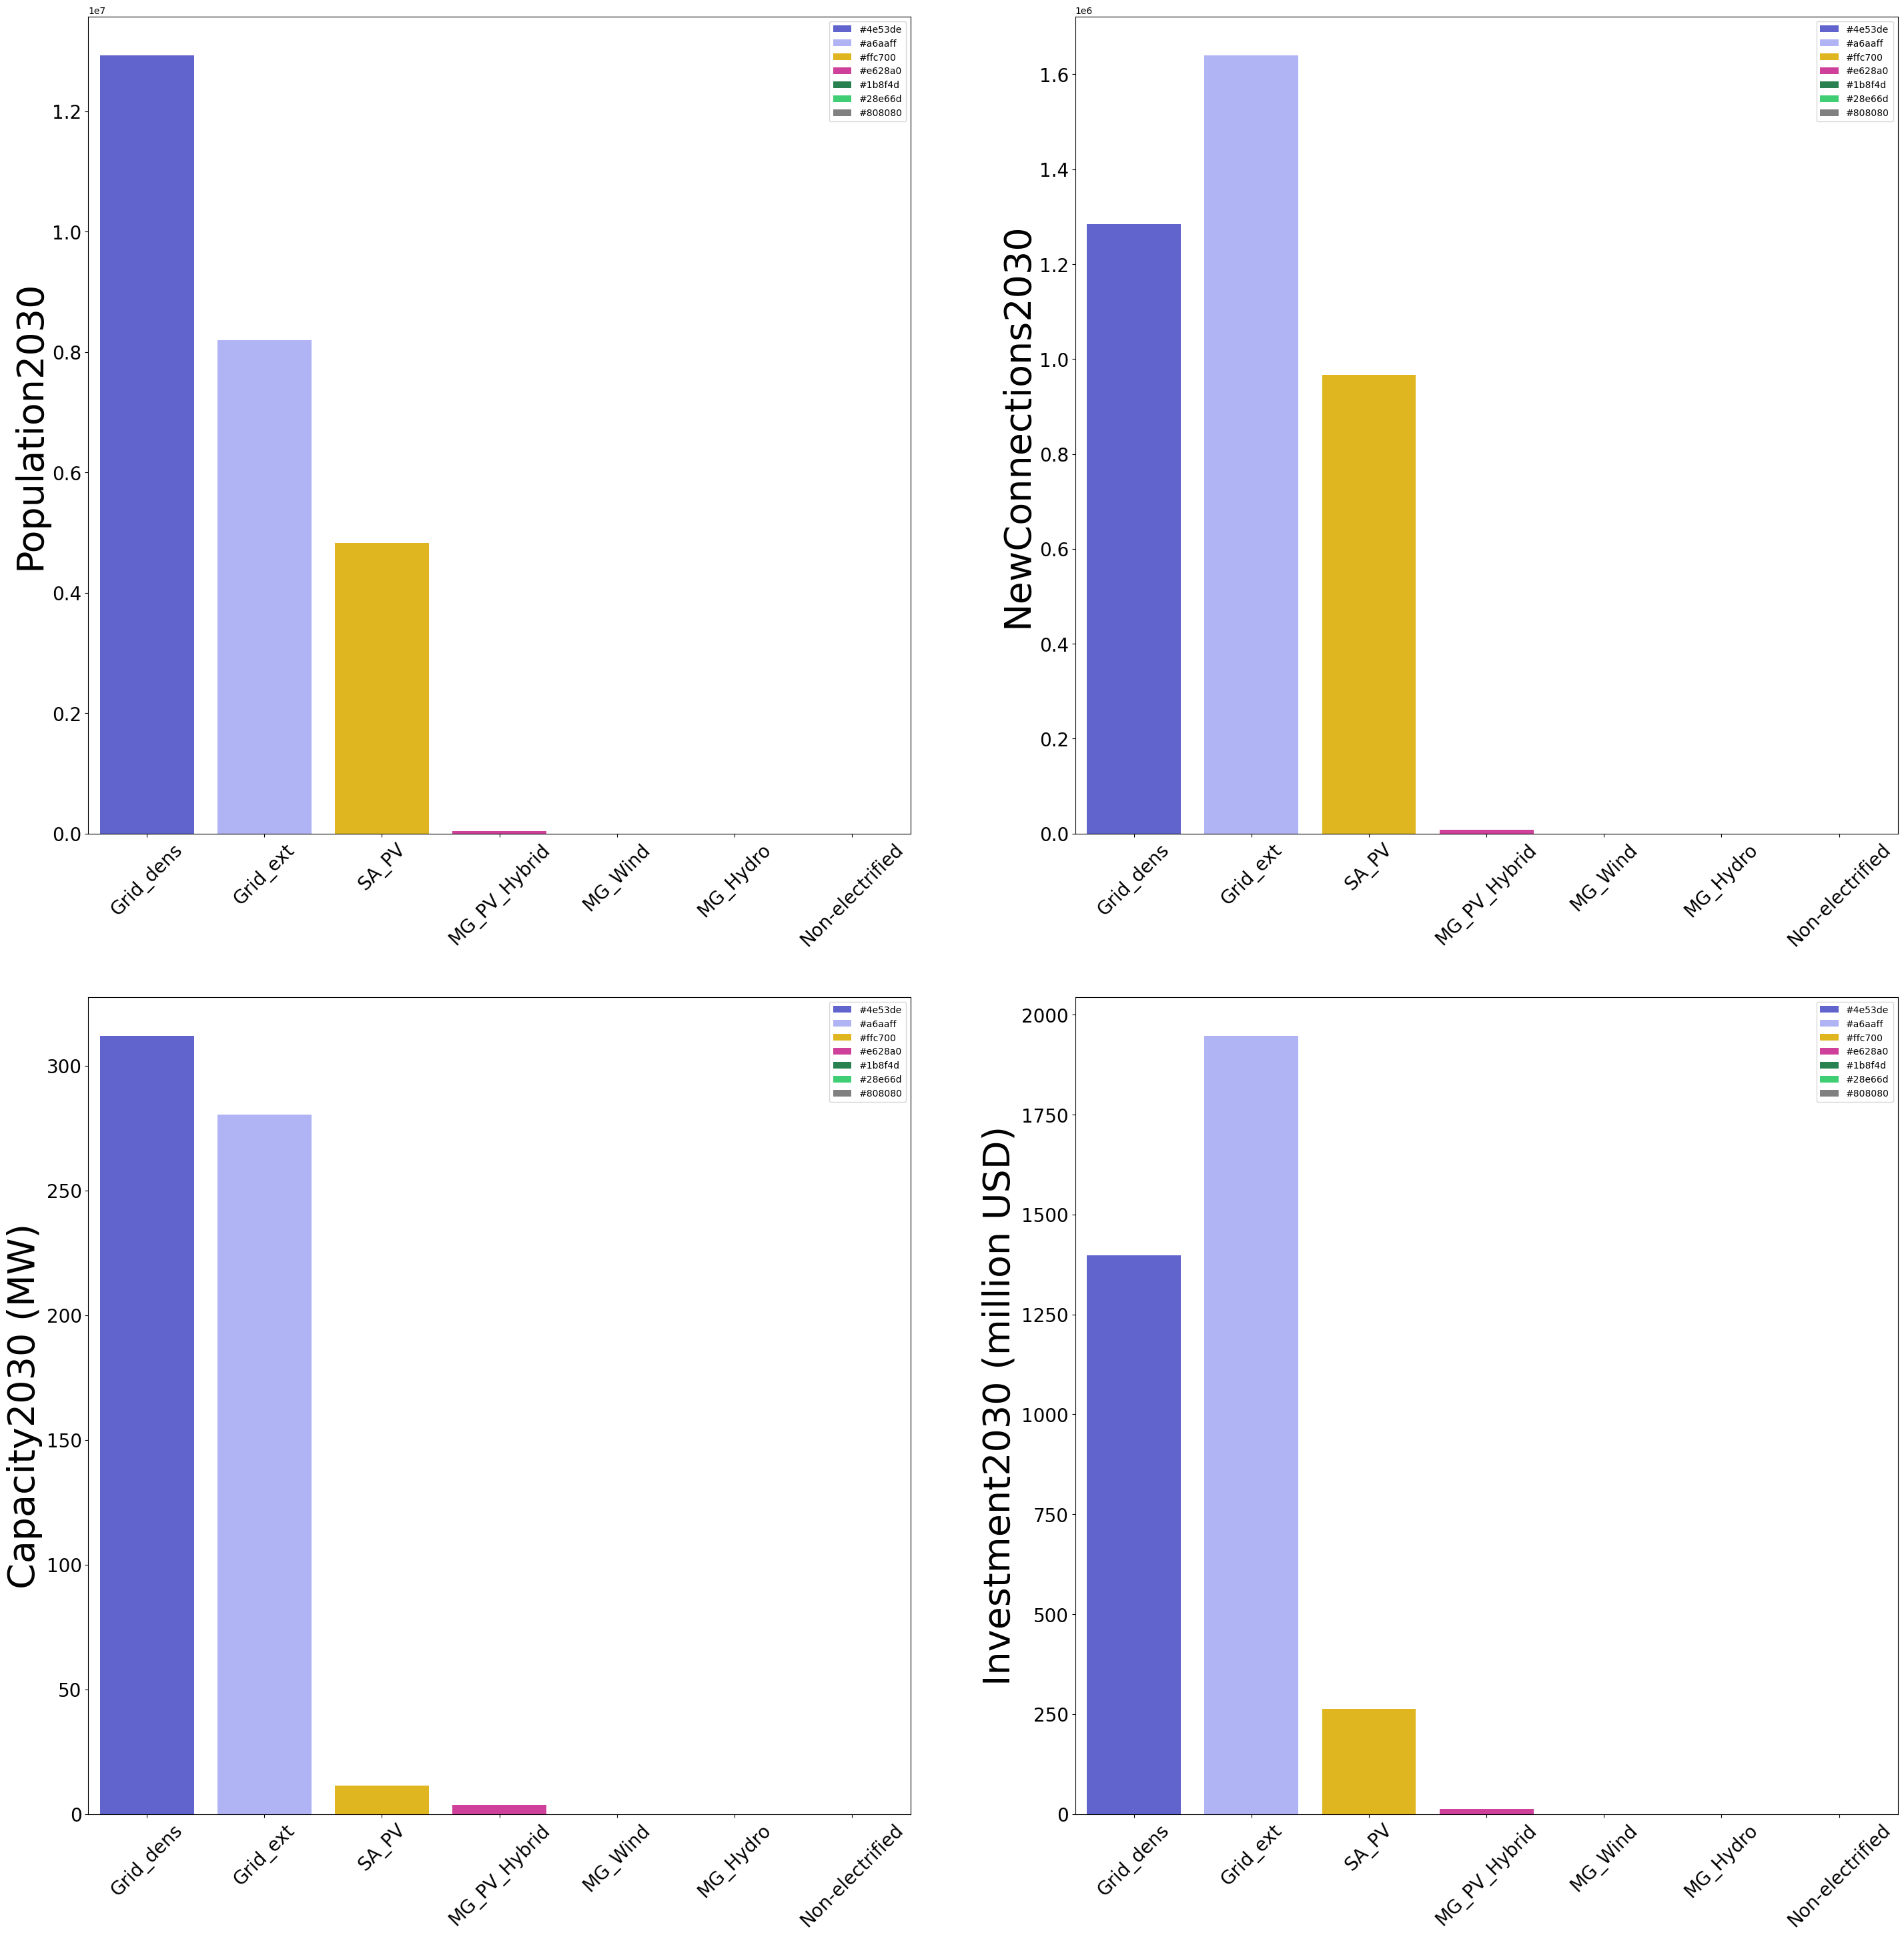

In [25]:
bar_plot(summary_table, columns, yearsofanalysis, techs)

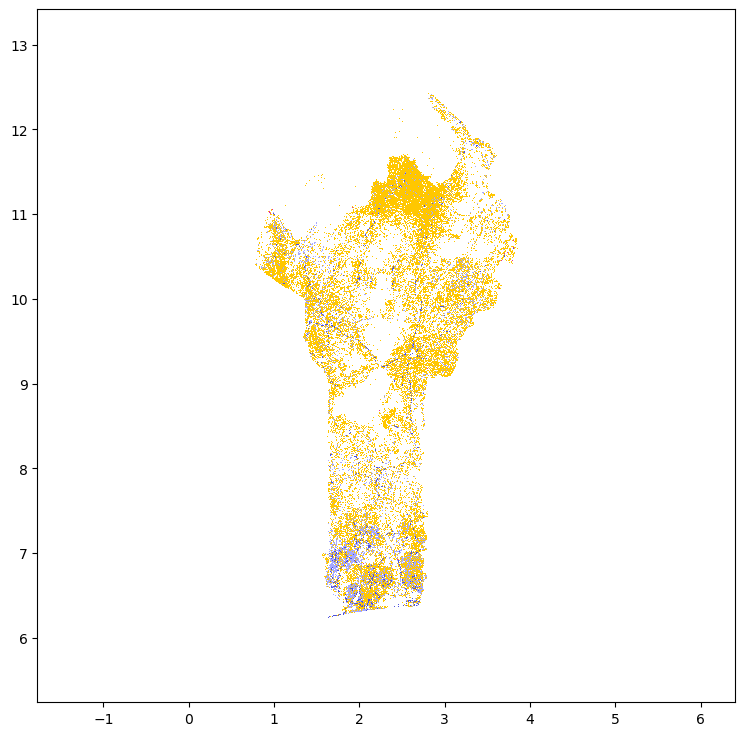

<Figure size 3000x3000 with 0 Axes>

Number of new PV Hybrid mini-grid locations:  13


In [26]:
map_plot(onsseter.df, end_year, start_year)

## 7. Exporting results

This code generates three csv files:
 - one containing all the results for the scenario created
 - one containing the summary for the scenario created
 - one containing some if the key input variables of the scenario

Before we proceed, please write the scenario_name in the first cell below. then move on to the next cell and run it to browse to the directory where you want to save your results. Sample file shall be located at .\ gep-onsset\sample_output. 

**Note that if you do not change the scenario name, the previous output files will be overwritten**

In [30]:
scenario_name = "hybrid_test"

In [31]:
messagebox.showinfo('OnSSET', 'Browse to the folder where you want to save the outputs')

output_dir = filedialog.askdirectory()
output_dir_variables = os.path.join(output_dir, '{}_Variables.csv'.format(scenario_name))
output_dir_results = os.path.join(output_dir, '{}_Results.csv'.format(scenario_name))
output_dir_summaries = os.path.join(output_dir, '{}_Summaries.csv'.format(scenario_name))

In [32]:
df_variables = save_variables(onsseter, start_year, end_year, end_electrification_rate_target, urban_target_tier, rural_target_tier_large,
                              rural_target_tier_small, auto_intensification, max_grid_intensification_cost, end_year_pop, urban_ratio_end_year,
                              grid_generation_cost, grid_power_plants_capital_cost, grid_losses, diesel_price, mg_hydro_capital_cost, min_mg_size,
                              mg_min_grid_dist, mg_interconnection, pv_cost, battery_cost, inverter_cost, diesel_gen_cost, max_diesel, 
                              sa_pv_capital_cost_1, sa_pv_capital_cost_2, sa_pv_capital_cost_3, sa_pv_capital_cost_4, sa_pv_capital_cost_5, 
                              grid_mv_line_cost, grid_lv_line_cost, grid_mv_line_capacity, grid_lv_line_capacity, grid_lv_line_max_length, hv_line_cost, 
                              grid_mv_line_max_length, annual_new_grid_connections_limit, annual_grid_cap_gen_limit, grid_discount_rate, 
                              mini_grid_discount_rate, standalone_discount_rate)

# Returning the result as a csv file
onsseter.df.to_csv(output_dir_results, index=False)

# Returning the summary as a csv file
summary_table.to_csv(output_dir_summaries, index=True)

# Returning the input variables as a csv file
df_variables.to_csv(output_dir_variables, index=False)

In [33]:
# Saving the new MV lines as a geojson file

for year in yearsofanalysis:
    try:
        try:
            os.remove(os.path.join(output_dir, 'new_mv_lines_{}_{}.geojson'.format(scenario_name, year)))
        except FileNotFoundError:
            pass
        with open(os.path.join(output_dir, 'new_mv_lines_{}_{}.geojson'.format(scenario_name, year)), 'w') as f:
            geojson.dump(new_lines_geojson[year], f)
        gdf = gpd.read_file(os.path.join(output_dir, 'new_mv_lines_{}_{}.geojson'.format(scenario_name, year)))
        gdf = gdf.set_crs(3395, allow_override=True)
        gdf = gdf.to_crs(4326)
        gdf.to_file(os.path.join(output_dir, 'new_mv_lines_{}_{}.geojson'.format(scenario_name, year)))
    except Exception as e:
        print(year, e)